# ANTLR 4

Il materiale di riferimento per le lezioni a venire è costituito da:

* Il libro (di testo) [The Definitive ANTLR 4 Reference](https://pragprog.com/book/tpantlr2/the-definitive-antlr-4-reference) di Terence Parr (l'autore di ANTLR),
* le [informazioni su target/runtime Python 3](https://github.com/antlr/antlr4/blob/master/doc/python-target.md),
* i [sorgenti del runtime Python 3](https://github.com/antlr/antlr4/tree/master/runtime/Python3),
* le [API Java](https://www.antlr.org/api/Java/) (utili a colmare la scarsezza della documentazione dei target/runtime Python 3),
* la [versione Python 3 degli esempi di codice](https://github.com/jszheng/py3antlr4book) del libro di cui sopra (non ufficiale),
* un [insieme di grammatiche](https://github.com/antlr/grammars-v4) di diversi linguaggi noti.

## Uso "diretto" (senza LibLET)

In [1]:
! rm -rf Hello*.*

In [2]:
%%writefile Hello.g

grammar Hello;            // Define a grammar called Hello
r  : 'hello' ID ;         // match keyword hello followed by an identifier
ID : [a-z]+ ;             // match lower-case identifiers
WS : [ \t\r\n]+ -> skip ; // skip spaces, tabs, newlines, \r (Windows)

Writing Hello.g


### Generazione dei moduli (usando il tool Java)

In [3]:
! java -jar "$ANTLR4_JAR" -Dlanguage=Python3 -visitor Hello.g && ls -l Hello*py

-rw-r--r-- 1 santini staff 1829 May 15 15:38 HelloLexer.py
-rw-r--r-- 1 santini staff  545 May 15 15:38 HelloListener.py
-rw-r--r-- 1 santini staff 2613 May 15 15:38 HelloParser.py
-rw-r--r-- 1 santini staff  481 May 15 15:38 HelloVisitor.py


### Parsing (costruzione dell'albero)

In [4]:
# codice dal runtime di antlr4

from antlr4.CommonTokenStream import CommonTokenStream
from antlr4.InputStream import InputStream

In [5]:
# codice genrerato da antlr4 a partire dalla grammatica Hello.g

from HelloLexer import HelloLexer
from HelloParser import HelloParser

In [6]:
text = 'hello massimo'

lexer = HelloLexer(InputStream(text))
stream = CommonTokenStream(lexer)
parser = HelloParser(stream)
tree = parser.r()

tree.toStringTree(recog = parser)

'(r hello massimo)'

#### Uso del lexer

In [7]:
lexer.reset()

while True:
    token = lexer.nextToken()
    print(token)
    if token.type == token.EOF: break

[@-1,0:4='hello',<1>,1:0]
[@-1,6:12='massimo',<2>,1:6]
[@-1,13:12='<EOF>',<-1>,1:13]


### Un esempio maggiormente complesso

In [8]:
! rm -f Expr*.*

In [9]:
%%writefile Expr.g

grammar Expr; 

/** The start rule; begin parsing here. */

prog:   stat+ ;

stat:   expr NEWLINE
    |   ID '=' expr NEWLINE
    |   NEWLINE
    ;

expr:   expr ('*'|'/') expr
    |   expr ('+'|'-') expr
    |   INT
    |   ID
    |   '(' expr ')'
    ;

MUL :   '*' ; // assigns token name to '*' used above in grammar
DIV :   '/' ;
ADD :   '+' ;
SUB :   '-' ;
ID  :   [a-zA-Z]+ ;      // match identifiers
INT :   [0-9]+ ;         // match integers
NEWLINE:'\r'? '\n' ;     // return newlines to parser (is end-statement signal)
WS : [ \t]+ -> skip ; // toss out whitespace    

Writing Expr.g


In [10]:
! java -jar "$ANTLR4_JAR" -Dlanguage=Python3 -visitor Expr.g && ls -l Expr*py

-rw-r--r-- 1 santini staff  2928 May 15 15:38 ExprLexer.py
-rw-r--r-- 1 santini staff  1034 May 15 15:38 ExprListener.py
-rw-r--r-- 1 santini staff 13174 May 15 15:38 ExprParser.py
-rw-r--r-- 1 santini staff   776 May 15 15:38 ExprVisitor.py


In [11]:
from ExprLexer import ExprLexer
from ExprParser import ExprParser

text = '2 * 3 + 4\n'

lexer = ExprLexer(InputStream(text))
stream = CommonTokenStream(lexer)
parser = ExprParser(stream)
tree = parser.prog()

tree.toStringTree(recog = parser)

'(prog (stat (expr (expr (expr 2) * (expr 3)) + (expr 4)) \\n))'

#### Uso del Listener

In [12]:
from antlr4.tree.Tree import ParseTreeWalker

In [13]:
from ExprListener import ExprListener

class PrintListener(ExprListener):
    def exitEveryRule(self, ctx):
        print(ctx.start, ctx.stop, ExprParser.ruleNames[ctx.getRuleIndex()])

listener = PrintListener()
ParseTreeWalker.DEFAULT.walk(listener, tree)

[@0,0:0='2',<9>,1:0] [@0,0:0='2',<9>,1:0] expr
[@2,4:4='3',<9>,1:4] [@2,4:4='3',<9>,1:4] expr
[@0,0:0='2',<9>,1:0] [@2,4:4='3',<9>,1:4] expr
[@4,8:8='4',<9>,1:8] [@4,8:8='4',<9>,1:8] expr
[@0,0:0='2',<9>,1:0] [@4,8:8='4',<9>,1:8] expr
[@0,0:0='2',<9>,1:0] [@5,9:9='\n',<10>,1:9] stat
[@0,0:0='2',<9>,1:0] [@5,9:9='\n',<10>,1:9] prog


#### Uso del Visitor

In [14]:
from ExprVisitor import ExprVisitor

class PrintVisitor(ExprVisitor):
    def visitChildren(self, node):
        print(node.start, node.stop, ExprParser.ruleNames[node.getRuleIndex()])
        return super().visitChildren(node)
        
visitor = PrintVisitor()
visitor.visit(tree)

[@0,0:0='2',<9>,1:0] [@5,9:9='\n',<10>,1:9] prog
[@0,0:0='2',<9>,1:0] [@5,9:9='\n',<10>,1:9] stat
[@0,0:0='2',<9>,1:0] [@4,8:8='4',<9>,1:8] expr
[@0,0:0='2',<9>,1:0] [@2,4:4='3',<9>,1:4] expr
[@0,0:0='2',<9>,1:0] [@0,0:0='2',<9>,1:0] expr
[@2,4:4='3',<9>,1:4] [@2,4:4='3',<9>,1:4] expr
[@4,8:8='4',<9>,1:8] [@4,8:8='4',<9>,1:8] expr


## Uso mediato da LibLET

In [15]:
from liblet import ANTLR, Tree, __version__

__version__

'0.12.1-alpha'

### Generazione e caricamento dei moduli

In [16]:
LabeledExpr = ANTLR(r"""
grammar LabeledExpr; // rename to distinguish from Expr.g4

prog:   stat+ ;

stat:   expr NEWLINE                # printExpr
    |   ID '=' expr NEWLINE         # assign
    |   NEWLINE                     # blank
    ;

expr:   expr op=('*'|'/') expr      # MulDiv
    |   expr op=('+'|'-') expr      # AddSub
    |   INT                         # int
    |   ID                          # id
    |   '(' expr ')'                # parens
    ;

MUL :   '*' ; // assigns token name to '*' used above in grammar
DIV :   '/' ;
ADD :   '+' ;
SUB :   '-' ;
ID  :   [a-zA-Z]+ ;      // match identifiers
INT :   [0-9]+ ;         // match integers
NEWLINE:'\r'? '\n' ;     // return newlines to parser (is end-statement signal)
WS : [ \t]+ -> skip ; // toss out whitespace
""")

### Generazione del parsing context

In [17]:
expr = '3 * 4 + 5\n'
LabeledExpr.context(expr, 'prog')

In [18]:
# come stringa

LabeledExpr.context(expr, 'prog', as_string = True)

'(prog (stat (expr (expr (expr 3) * (expr 4)) + (expr 5)) \\n))'

### Generazione di un Tree ("annotato")

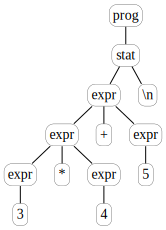

In [19]:
# semplice

LabeledExpr.tree(expr, 'prog', simple = True)

Si può ottenere un albero annotato, ossia un `Tree` i cui nodi siano `dict`. In tal caso ogni nodo contiene la chiave `type` che può valere `rule` o `token` e `name` che corrisponde al nome della regola (o token, se presente nella parte del *lexer*). Inotre, per i *token* che hanno un nome definito nel *lexer* c'è la chiave `value` che contiene il contenuto del token, mentre per le *rule* c'è sempre il campo `label` che nel caso la regola sia etichettata contiene l'etichetta.

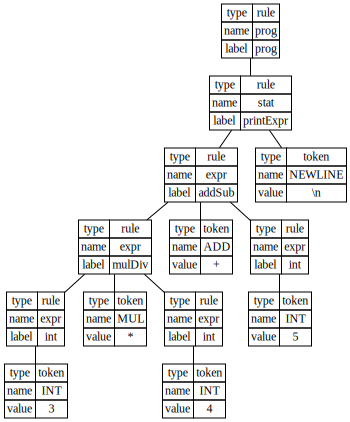

In [20]:
LabeledExpr.tree(expr, 'prog')

#### Lista dei token (numerati)

In [21]:
for token in LabeledExpr.tokens(expr): print(token)

[@0,0:0='3',<9>,1:0]
[@1,2:2='*',<4>,1:2]
[@2,4:4='4',<9>,1:4]
[@3,6:6='+',<6>,1:6]
[@4,8:8='5',<9>,1:8]
[@5,9:9='\n',<10>,1:9]
[@6,10:9='<EOF>',<-1>,2:0]


### Valutazione (con Visitor)

In [22]:
class EvalVisitor(LabeledExpr.Visitor):

    def __init__(self):
        self.memory = {}
        
    def visitAssign(self, ctx):
        name = ctx.ID().getText()
        value = self.visit(ctx.expr())
        self.memory[name] = value
        return value

    def visitPrintExpr(self, ctx):
        value = self.visit(ctx.expr())
        print(value)

    def visitInt(self, ctx):
        return int(ctx.INT().getText())

    def visitId(self, ctx):
        name = ctx.ID().getText()
        if name in self.memory: return self.memory[name]
        return 0

    def visitMulDiv(self, ctx):
        left = self.visit(ctx.expr(0))
        right = self.visit(ctx.expr(1))
        if ctx.op.type == LabeledExpr.Parser.MUL:
            return left * right
        else:
            return left / right

    def visitAddSub(self, ctx):
        left = self.visit(ctx.expr(0))
        right = self.visit(ctx.expr(1))
        if ctx.op.type == LabeledExpr.Parser.ADD:
            return left + right
        else:
            return left - right

    def visitParens(self, ctx):
        return self.visit(ctx.expr())

In [23]:
expr = """
3 + 4
A = 2
A + 2 * 3
"""

ctx = LabeledExpr.context(expr, 'prog')
visitor = EvalVisitor()
visitor.visit(ctx)

7
8


### Numerazione degli assegnamenti (con Listener)

In [24]:
class LineNumberingListener(LabeledExpr.Listener):
    def __init__(self):
        self.assign_num = 0
    def enterAssign(self, ctx):
        print(self.assign_num, ctx.getText().strip())
        self.assign_num += 1

In [25]:
expr = """
A = 1
3 + A
B = 2
B + 2 * 3
C = 4
C * C
"""

ctx = LabeledExpr.context(expr, 'prog')
listener = LineNumberingListener()
ParseTreeWalker.DEFAULT.walk(listener, ctx)

0 A=1
1 B=2
2 C=4


### Diagnostici

In [26]:
Ambig = ANTLR(r"""
grammar Ambig;

stat: expr ';'
    | ID '(' ')' ';' 
    ;
expr: ID '(' ')' 
    | INT
    ;

INT :   [0-9]+ ;
ID  :   [a-zA-Z]+ ;
WS  :   [ \t\r\n]+ -> skip ;
""")

text = 'f();'

In [27]:
Ambig.context(text, 'stat', diag = True)

line 1:3 reportAttemptingFullContext d=0 (stat), input='f();'
line 1:3 reportAmbiguity d=0 (stat): ambigAlts={1, 2}, input='f();'


In [28]:
Ambig.context(text, 'stat', trace = True)

enter   stat, LT(1)=f
enter   expr, LT(1)=f
consume [@0,0:0='f',<5>,1:0] rule expr
consume [@1,1:1='(',<2>,1:1] rule expr
consume [@2,2:2=')',<3>,1:2] rule expr
exit    expr, LT(1)=;
consume [@3,3:3=';',<1>,1:3] rule stat
exit    stat, LT(1)=<EOF>
